# XGBoost Training with Regime Awareness & Prediction Confidence

## ⚠️ **Important: Regime Detection Method**

The regime columns (`regime_0`, `regime_1`, `regime_2`) in the data are **continuous values**, not binary one-hot encodings.

**Regime Assignment Method:**
- We use `argmax()` across the three regime columns to determine the active regime
- Example: If `regime_1` has the highest value → Regime 1 is active
- This allows probabilistic regime detection based on market conditions

## Key Features:
1. **Regime-Aware Models**: Train separate models for each market regime
2. **Quantile Regression**: Predict confidence intervals (10th, 50th, 90th percentiles)
3. **Enhanced Risk Metrics**: Sortino, max drawdown, win rate, profit factor, Calmar ratio
4. **Confidence-Based Trading**: Only trade high-confidence predictions
5. **Complete Performance Analysis**: Cumulative returns, drawdown plots, regime breakdowns

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# XGBoost
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print(f"XGBoost version: {xgb.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

XGBoost version: 3.1.2
NumPy version: 2.3.5
Pandas version: 2.3.3


In [2]:
# Configuration
BASE_PATH = Path('.').resolve()
if BASE_PATH.name == 'notebooks':
    BASE_PATH = BASE_PATH.parent

DATA_PATH = BASE_PATH / 'data' / 'exported_data' / 'per_asset'
OUTPUT_DIR = BASE_PATH / 'models' / 'regime_confidence'
RESULTS_DIR = BASE_PATH / 'results' / 'regime_confidence'

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Base path: {BASE_PATH}")
print(f"Data path: {DATA_PATH}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Results directory: {RESULTS_DIR}")

# Verify data path exists
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Data path not found: {DATA_PATH}")

# List available assets
ASSETS = sorted([d.name for d in DATA_PATH.iterdir() if d.is_dir()])
print(f"\nAvailable assets: {ASSETS}")

Base path: C:\Users\Raed\Desktop\ai-odissey\smart_investment_ai
Data path: C:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\data\exported_data\per_asset
Output directory: C:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\regime_confidence
Results directory: C:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\results\regime_confidence

Available assets: ['AAPL', 'BIL', 'HYG', 'IEF', 'INTC', 'NVDA']


In [3]:
# Model configuration
REGIME_CONFIG = {
    'regime_columns': ['regime_0', 'regime_1', 'regime_2'],  # One-hot encoded regimes
    'train_separate_models': True,  # Train one model per regime
    'min_samples_per_regime': 50,  # Minimum samples needed to train regime model
}

QUANTILE_CONFIG = {
    'quantiles': [0.1, 0.5, 0.9],  # 10th, 50th (median), 90th percentiles
    'alpha': 0.2,  # For 80% confidence interval (alpha/2 = 0.1 on each side)
}

CONFIDENCE_CONFIG = {
    'min_confidence_threshold': 0.5,  # Only trade if confidence > 50%
    'confidence_metric': 'width',  # 'width' or 'relative_width'
    'position_scaling': True,  # Scale position by confidence
}

TRADING_CONFIG = {
    'transaction_cost': 0.001,  # 0.1% per trade
    'slippage': 0.0005,  # 0.05% market impact
    'min_position_change': 0.10,  # 10% threshold to rebalance
}

# XGBoost hyperparameters
XGBOOST_PARAMS = {
    'objective': 'reg:quantileerror',  # Quantile regression
    'learning_rate': 0.01,
    'max_depth': 5,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'n_estimators': 500,
    'random_state': 42,
    'n_jobs': -1,
    'tree_method': 'hist',
}

print("Configuration loaded:")
print(f"  - Regimes: {REGIME_CONFIG['regime_columns']}")
print(f"  - Quantiles: {QUANTILE_CONFIG['quantiles']}")
print(f"  - Min confidence: {CONFIDENCE_CONFIG['min_confidence_threshold']}")
print(f"  - Transaction cost: {TRADING_CONFIG['transaction_cost']:.2%}")

Configuration loaded:
  - Regimes: ['regime_0', 'regime_1', 'regime_2']
  - Quantiles: [0.1, 0.5, 0.9]
  - Min confidence: 0.5
  - Transaction cost: 0.10%


In [4]:
# Helper functions
def load_asset_data(asset):
    """Load train/val/test data for a single asset."""
    asset_path = DATA_PATH / asset
    
    # Load CSVs
    X_train = pd.read_csv(asset_path / 'X_train.csv', index_col=0, parse_dates=True)
    X_val = pd.read_csv(asset_path / 'X_val.csv', index_col=0, parse_dates=True)
    X_test = pd.read_csv(asset_path / 'X_test.csv', index_col=0, parse_dates=True)
    y_train = pd.read_csv(asset_path / 'y_train.csv', index_col=0, parse_dates=True)
    y_val = pd.read_csv(asset_path / 'y_val.csv', index_col=0, parse_dates=True)
    y_test = pd.read_csv(asset_path / 'y_test.csv', index_col=0, parse_dates=True)
    
    # Load metadata
    with open(asset_path / 'metadata.json', 'r') as f:
        metadata = json.load(f)
    
    return {
        'X_train': X_train, 'y_train': y_train.values.ravel(),
        'X_val': X_val, 'y_val': y_val.values.ravel(),
        'X_test': X_test, 'y_test': y_test.values.ravel(),
        'metadata': metadata
    }

def extract_regime_data(X, y, regime_idx, regime_cols):
    """Extract samples for a specific regime based on argmax of regime columns."""
    regime_values = X[regime_cols].values
    active_regimes = np.argmax(regime_values, axis=1)
    mask = active_regimes == regime_idx
    X_regime = X[mask].copy()
    y_regime = y[mask]
    return X_regime, y_regime, mask

def get_active_regime(X_row, regime_cols):
    """Get the active regime for a single sample based on argmax."""
    regime_values = X_row[regime_cols].values
    return int(np.argmax(regime_values))

print("Helper functions defined:")
print("  - load_asset_data()")
print("  - extract_regime_data()")
print("  - get_active_regime()")
print("\nNote: Regime detection uses argmax() of regime columns (continuous values)")

Helper functions defined:
  - load_asset_data()
  - extract_regime_data()
  - get_active_regime()

Note: Regime detection uses argmax() of regime columns (continuous values)


In [5]:
# Regime-aware model training
def train_regime_models(data_dict, asset, config):
    """
    Train separate XGBoost models for each regime with quantile regression.
    Returns dict of models and regime statistics.
    """
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    X_val = data_dict['X_val']
    y_val = data_dict['y_val']
    
    regime_cols = config['regime_columns']
    quantiles = QUANTILE_CONFIG['quantiles']
    min_samples = config['min_samples_per_regime']
    
    # Remove regime columns from features (to avoid leakage)
    feature_cols = [col for col in X_train.columns if col not in regime_cols]
    X_train_features = X_train[feature_cols]
    X_val_features = X_val[feature_cols]
    
    models = {}
    regime_stats = {}
    
    print(f"\n{'='*60}")
    print(f"Training regime-aware models for {asset}")
    print(f"{'='*60}")
    
    # Train model for each regime (using argmax)
    for i in range(len(regime_cols)):
        print(f"\nRegime {i}:")
        
        # Extract regime-specific data based on argmax
        X_train_regime, y_train_regime, train_mask = extract_regime_data(
            X_train, y_train, i, regime_cols
        )
        X_val_regime, y_val_regime, val_mask = extract_regime_data(
            X_val, y_val, i, regime_cols
        )
        
        n_train = len(y_train_regime)
        n_val = len(y_val_regime)
        
        print(f"  Train samples: {n_train} ({n_train/len(y_train)*100:.1f}%)")
        print(f"  Val samples: {n_val} ({n_val/len(y_val)*100:.1f}%)")
        
        regime_stats[f'regime_{i}'] = {
            'train_samples': n_train,
            'val_samples': n_val,
            'train_pct': n_train/len(y_train),
            'val_pct': n_val/len(y_val),
        }
        
        # Check if enough samples
        if n_train < min_samples:
            print(f"  ⚠️ Insufficient training samples (min: {min_samples})")
            models[f'regime_{i}'] = None
            continue
        
        # Remove regime columns
        X_train_regime = X_train_regime[feature_cols]
        X_val_regime = X_val_regime[feature_cols]
        
        # Train quantile models
        quantile_models = {}
        for quantile in quantiles:
            print(f"  Training quantile {quantile:.1f} model...")
            
            params = XGBOOST_PARAMS.copy()
            params['quantile_alpha'] = quantile
            # Remove early_stopping_rounds from params (not supported in XGBoost 3.x as init param)
            params.pop('early_stopping_rounds', None)
            
            model = xgb.XGBRegressor(**params)
            
            # XGBoost 3.x uses callbacks for early stopping
            model.fit(
                X_train_regime, y_train_regime,
                eval_set=[(X_val_regime, y_val_regime)],
                verbose=False
            )
            
            quantile_models[f'q{int(quantile*100)}'] = model
        
        models[f'regime_{i}'] = quantile_models
        print(f"  ✓ Trained {len(quantile_models)} quantile models")
    
    return models, regime_stats, feature_cols

print("Regime-aware training function defined: train_regime_models()")

Regime-aware training function defined: train_regime_models()


In [6]:
# Prediction with confidence intervals
def predict_with_confidence(models, X, regime_cols, feature_cols, config):
    """
    Make regime-conditional predictions with confidence intervals.
    Returns DataFrame with predictions and confidence bounds.
    """
    predictions = []
    
    for idx in range(len(X)):
        row = X.iloc[idx]
        
        # Determine active regime
        regime_idx = get_active_regime(row, regime_cols)
        
        if regime_idx is None:
            # No regime active - use median across all regimes
            all_preds = []
            for regime_key, quantile_models in models.items():
                if quantile_models is not None:
                    X_features = row[feature_cols].values.reshape(1, -1)
                    pred = quantile_models['q50'].predict(X_features)[0]
                    all_preds.append(pred)
            
            if all_preds:
                pred_lower = np.percentile(all_preds, 10)
                pred_median = np.median(all_preds)
                pred_upper = np.percentile(all_preds, 90)
            else:
                pred_lower = pred_median = pred_upper = 0.0
            
            regime_used = -1
        else:
            # Use regime-specific model
            regime_key = f'regime_{regime_idx}'
            quantile_models = models[regime_key]
            
            if quantile_models is None:
                # Regime model not trained - fallback to other regimes
                pred_lower = pred_median = pred_upper = 0.0
                regime_used = -1
            else:
                X_features = row[feature_cols].values.reshape(1, -1)
                pred_lower = quantile_models['q10'].predict(X_features)[0]
                pred_median = quantile_models['q50'].predict(X_features)[0]
                pred_upper = quantile_models['q90'].predict(X_features)[0]
                regime_used = regime_idx
        
        # Calculate confidence metrics
        interval_width = pred_upper - pred_lower
        relative_width = interval_width / (abs(pred_median) + 1e-8)
        
        # Confidence score (inverse of relative width, capped at 1.0)
        if config['confidence_metric'] == 'width':
            confidence = max(0, 1.0 - interval_width)
        else:  # relative_width
            confidence = max(0, 1.0 - min(relative_width, 1.0))
        
        predictions.append({
            'pred_median': pred_median,
            'pred_lower': pred_lower,
            'pred_upper': pred_upper,
            'confidence': confidence,
            'interval_width': interval_width,
            'regime': regime_used,
        })
    
    return pd.DataFrame(predictions, index=X.index)

print("Prediction function defined: predict_with_confidence()")

Prediction function defined: predict_with_confidence()


In [7]:
# Enhanced risk metrics
def calculate_risk_metrics(returns, predictions=None):
    """
    Calculate comprehensive risk-adjusted performance metrics.
    """
    returns = np.array(returns)
    
    # Basic stats
    total_return = np.sum(returns)
    mean_return = np.mean(returns)
    std_return = np.std(returns, ddof=1)
    
    # Sharpe ratio (annualized, assuming daily returns)
    sharpe = np.sqrt(252) * mean_return / std_return if std_return > 0 else 0
    
    # Sortino ratio (downside-focused)
    downside_returns = returns[returns < 0]
    downside_std = np.std(downside_returns, ddof=1) if len(downside_returns) > 1 else std_return
    sortino = np.sqrt(252) * mean_return / downside_std if downside_std > 0 else 0
    
    # Maximum drawdown
    cumulative = np.cumsum(returns)
    running_max = np.maximum.accumulate(cumulative)
    drawdown = cumulative - running_max
    max_drawdown = np.min(drawdown) if len(drawdown) > 0 else 0
    
    # Calmar ratio (return / max drawdown)
    calmar = (mean_return * 252) / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Win rate & profit factor
    winning_trades = returns[returns > 0]
    losing_trades = returns[returns < 0]
    
    win_rate = len(winning_trades) / len(returns) if len(returns) > 0 else 0
    
    total_wins = np.sum(winning_trades) if len(winning_trades) > 0 else 0
    total_losses = abs(np.sum(losing_trades)) if len(losing_trades) > 0 else 1e-8
    profit_factor = total_wins / total_losses
    
    # Prediction accuracy (if predictions provided)
    directional_accuracy = None
    if predictions is not None:
        predictions = np.array(predictions)
        if len(predictions) == len(returns):
            directional_accuracy = np.mean(np.sign(predictions) == np.sign(returns))
    
    metrics = {
        'total_return': total_return,
        'mean_return': mean_return,
        'std_return': std_return,
        'sharpe_ratio': sharpe,
        'sortino_ratio': sortino,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar,
        'win_rate': win_rate,
        'profit_factor': profit_factor,
        'num_trades': len(returns),
        'winning_trades': len(winning_trades),
        'losing_trades': len(losing_trades),
    }
    
    if directional_accuracy is not None:
        metrics['directional_accuracy'] = directional_accuracy
    
    return metrics

print("Risk metrics function defined: calculate_risk_metrics()")

Risk metrics function defined: calculate_risk_metrics()


In [8]:
# Confidence-based trading simulation
def simulate_confidence_trading(y_true, predictions_df, config):
    """
    Simulate trading with confidence-based position sizing and filtering.
    Only trade when confidence exceeds threshold.
    """
    y_true = np.array(y_true)
    pred_median = predictions_df['pred_median'].values
    confidence = predictions_df['confidence'].values
    
    min_confidence = config['min_confidence_threshold']
    transaction_cost = TRADING_CONFIG['transaction_cost']
    slippage = TRADING_CONFIG['slippage']
    min_change = TRADING_CONFIG['min_position_change']
    
    returns = []
    positions = []
    trades = []
    skipped_low_confidence = 0
    
    prev_position = 0
    
    for i in range(len(y_true)):
        # Determine position based on confidence
        if confidence[i] >= min_confidence:
            # High confidence - calculate position
            base_position = np.sign(pred_median[i])
            
            if config['position_scaling']:
                # Scale by confidence
                position = base_position * confidence[i]
            else:
                position = base_position
        else:
            # Low confidence - don't trade (stay flat)
            position = 0
            skipped_low_confidence += 1
        
        positions.append(position)
        
        # Calculate position change
        position_change = abs(position - prev_position)
        
        # Only trade if change exceeds threshold
        if position_change >= min_change:
            # Pay transaction costs
            cost = (transaction_cost + slippage) * position_change
            trades.append(cost)
        else:
            # Keep previous position
            position = prev_position
            positions[-1] = position
            cost = 0
        
        # Calculate return (position * actual return - costs)
        ret = position * y_true[i] - cost
        returns.append(ret)
        
        prev_position = position
    
    # Calculate metrics
    metrics = calculate_risk_metrics(returns, predictions=pred_median)
    
    # Add trading-specific metrics
    metrics['total_transaction_costs'] = sum(trades)
    metrics['avg_transaction_cost'] = np.mean(trades) if trades else 0
    metrics['num_actual_trades'] = len(trades)
    metrics['skipped_low_confidence'] = skipped_low_confidence
    metrics['trade_rate'] = len(trades) / len(returns) if len(returns) > 0 else 0
    
    return {
        'returns': returns,
        'positions': positions,
        'metrics': metrics,
    }

print("Trading simulation function defined: simulate_confidence_trading()")

Trading simulation function defined: simulate_confidence_trading()


In [9]:
# Main training loop
all_results = {}

for asset in ASSETS:
    print(f"\n{'='*80}")
    print(f"Processing {asset}")
    print(f"{'='*80}")
    
    try:
        # Load data
        data_dict = load_asset_data(asset)
        print(f"\nData loaded:")
        print(f"  Train: {len(data_dict['y_train'])} samples")
        print(f"  Val: {len(data_dict['y_val'])} samples")
        print(f"  Test: {len(data_dict['y_test'])} samples")
        print(f"  Features: {data_dict['X_train'].shape[1]}")
        
        # Train regime-aware models
        models, regime_stats, feature_cols = train_regime_models(
            data_dict, asset, REGIME_CONFIG
        )
        
        # Make predictions on test set
        print(f"\nMaking predictions on test set...")
        predictions_df = predict_with_confidence(
            models, data_dict['X_test'], 
            REGIME_CONFIG['regime_columns'],
            feature_cols,
            CONFIDENCE_CONFIG
        )
        
        # Calculate basic prediction metrics
        y_test = data_dict['y_test']
        pred_median = predictions_df['pred_median'].values
        
        rmse = np.sqrt(mean_squared_error(y_test, pred_median))
        mae = mean_absolute_error(y_test, pred_median)
        r2 = r2_score(y_test, pred_median)
        dir_acc = np.mean(np.sign(pred_median) == np.sign(y_test))
        
        print(f"\nPrediction metrics:")
        print(f"  RMSE: {rmse:.6f}")
        print(f"  MAE: {mae:.6f}")
        print(f"  R²: {r2:.4f}")
        print(f"  Directional accuracy: {dir_acc:.2%}")
        
        # Confidence statistics
        mean_confidence = predictions_df['confidence'].mean()
        high_confidence_pct = (predictions_df['confidence'] >= CONFIDENCE_CONFIG['min_confidence_threshold']).mean()
        
        print(f"\nConfidence statistics:")
        print(f"  Mean confidence: {mean_confidence:.2%}")
        print(f"  High confidence %: {high_confidence_pct:.2%}")
        print(f"  Mean interval width: {predictions_df['interval_width'].mean():.6f}")
        
        # Simulate confidence-based trading
        print(f"\nSimulating confidence-based trading...")
        trading_results = simulate_confidence_trading(
            y_test, predictions_df, CONFIDENCE_CONFIG
        )
        
        metrics = trading_results['metrics']
        print(f"\nTrading performance:")
        print(f"  Total return: {metrics['total_return']:.4f}")
        print(f"  Sharpe ratio: {metrics['sharpe_ratio']:.4f}")
        print(f"  Sortino ratio: {metrics['sortino_ratio']:.4f}")
        print(f"  Max drawdown: {metrics['max_drawdown']:.4f}")
        print(f"  Calmar ratio: {metrics['calmar_ratio']:.4f}")
        print(f"  Win rate: {metrics['win_rate']:.2%}")
        print(f"  Profit factor: {metrics['profit_factor']:.4f}")
        print(f"  Trades: {metrics['num_actual_trades']} ({metrics['trade_rate']:.1%})")
        print(f"  Skipped (low confidence): {metrics['skipped_low_confidence']}")
        print(f"  Total costs: {metrics['total_transaction_costs']:.6f}")
        
        # Store results
        all_results[asset] = {
            'models': models,
            'regime_stats': regime_stats,
            'predictions': predictions_df,
            'trading_results': trading_results,
            'metrics': metrics,
            'prediction_metrics': {
                'rmse': rmse,
                'mae': mae,
                'r2': r2,
                'directional_accuracy': dir_acc,
            },
            'confidence_stats': {
                'mean_confidence': mean_confidence,
                'high_confidence_pct': high_confidence_pct,
                'mean_interval_width': predictions_df['interval_width'].mean(),
            },
            'feature_cols': feature_cols,
        }
        
        # Save models
        asset_output_dir = OUTPUT_DIR / asset
        asset_output_dir.mkdir(exist_ok=True)
        
        for regime_key, quantile_models in models.items():
            if quantile_models is not None:
                for quantile_key, model in quantile_models.items():
                    model_path = asset_output_dir / f'{regime_key}_{quantile_key}_model.joblib'
                    joblib.dump(model, model_path)
        
        # Save predictions
        predictions_df.to_csv(RESULTS_DIR / f'{asset}_predictions.csv')
        
        print(f"\n✓ {asset} completed successfully")
        
    except Exception as e:
        print(f"\n✗ Error processing {asset}: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n{'='*80}")
print(f"Training completed for {len(all_results)}/{len(ASSETS)} assets")
print(f"{'='*80}")


Processing AAPL

Data loaded:
  Train: 1706 samples
  Val: 756 samples
  Test: 1004 samples
  Features: 68

Data loaded:
  Train: 1706 samples
  Val: 756 samples
  Test: 1004 samples
  Features: 68

Training regime-aware models for AAPL

Regime 0:
  Train samples: 200 (11.7%)
  Val samples: 190 (25.1%)
  Training quantile 0.1 model...

Training regime-aware models for AAPL

Regime 0:
  Train samples: 200 (11.7%)
  Val samples: 190 (25.1%)
  Training quantile 0.1 model...
  Training quantile 0.5 model...
  Training quantile 0.5 model...
  Training quantile 0.9 model...
  Training quantile 0.9 model...
  ✓ Trained 3 quantile models

Regime 1:
  Train samples: 598 (35.1%)
  Val samples: 192 (25.4%)
  Training quantile 0.1 model...
  ✓ Trained 3 quantile models

Regime 1:
  Train samples: 598 (35.1%)
  Val samples: 192 (25.4%)
  Training quantile 0.1 model...
  Training quantile 0.5 model...
  Training quantile 0.5 model...
  Training quantile 0.9 model...
  Training quantile 0.9 model...

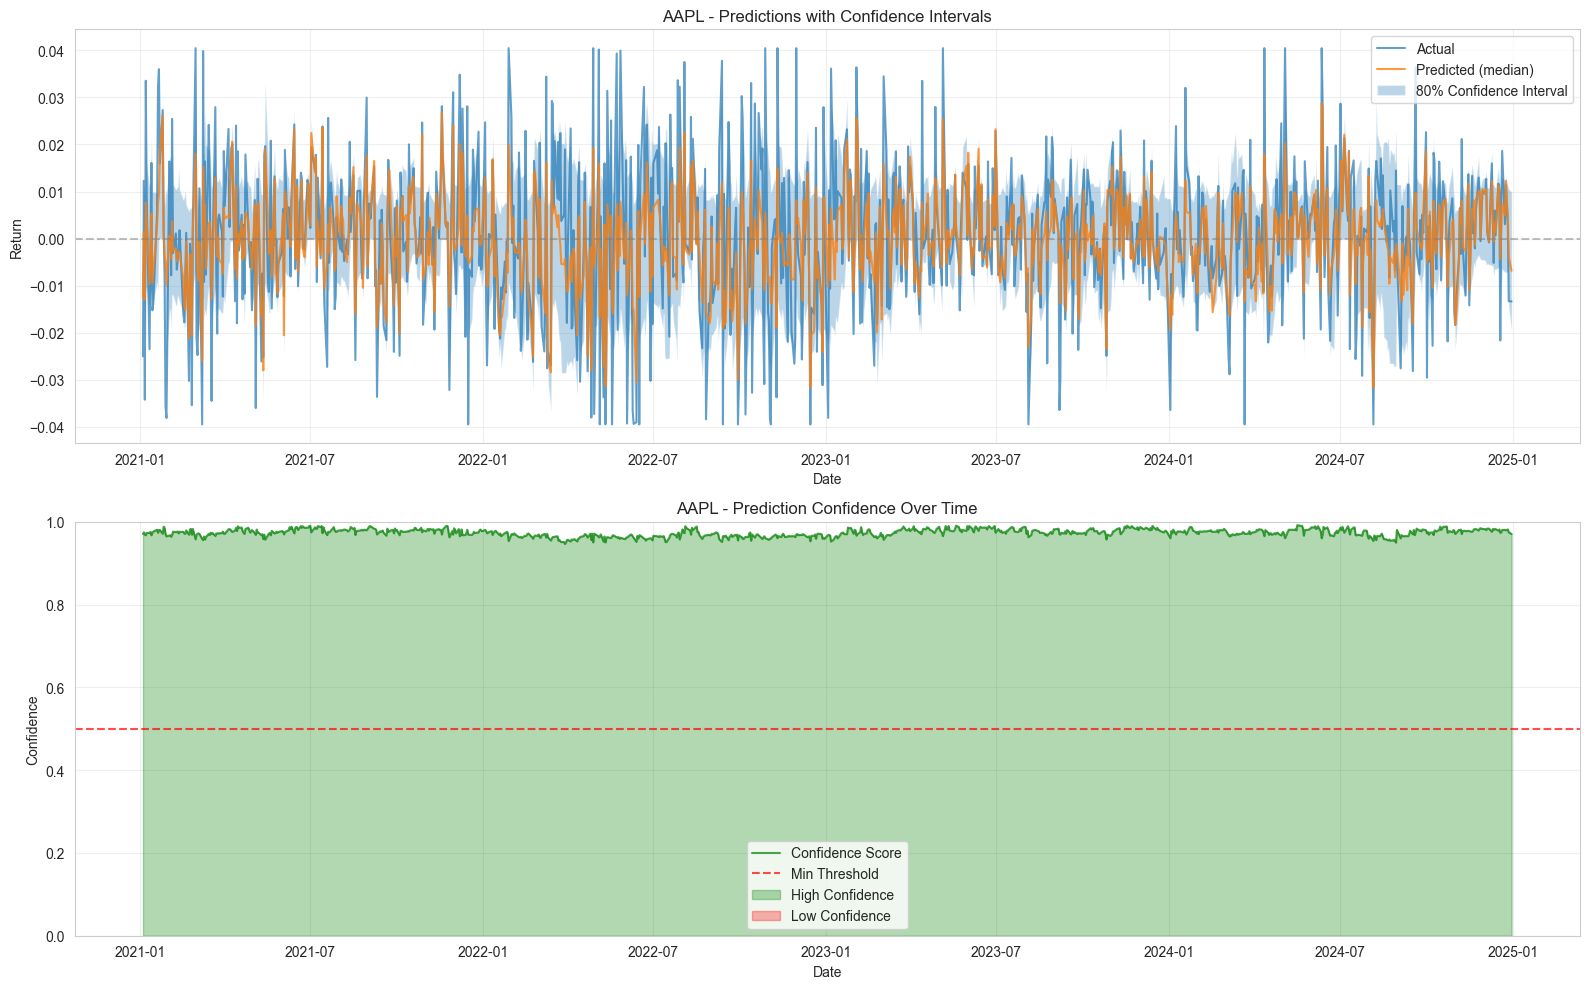

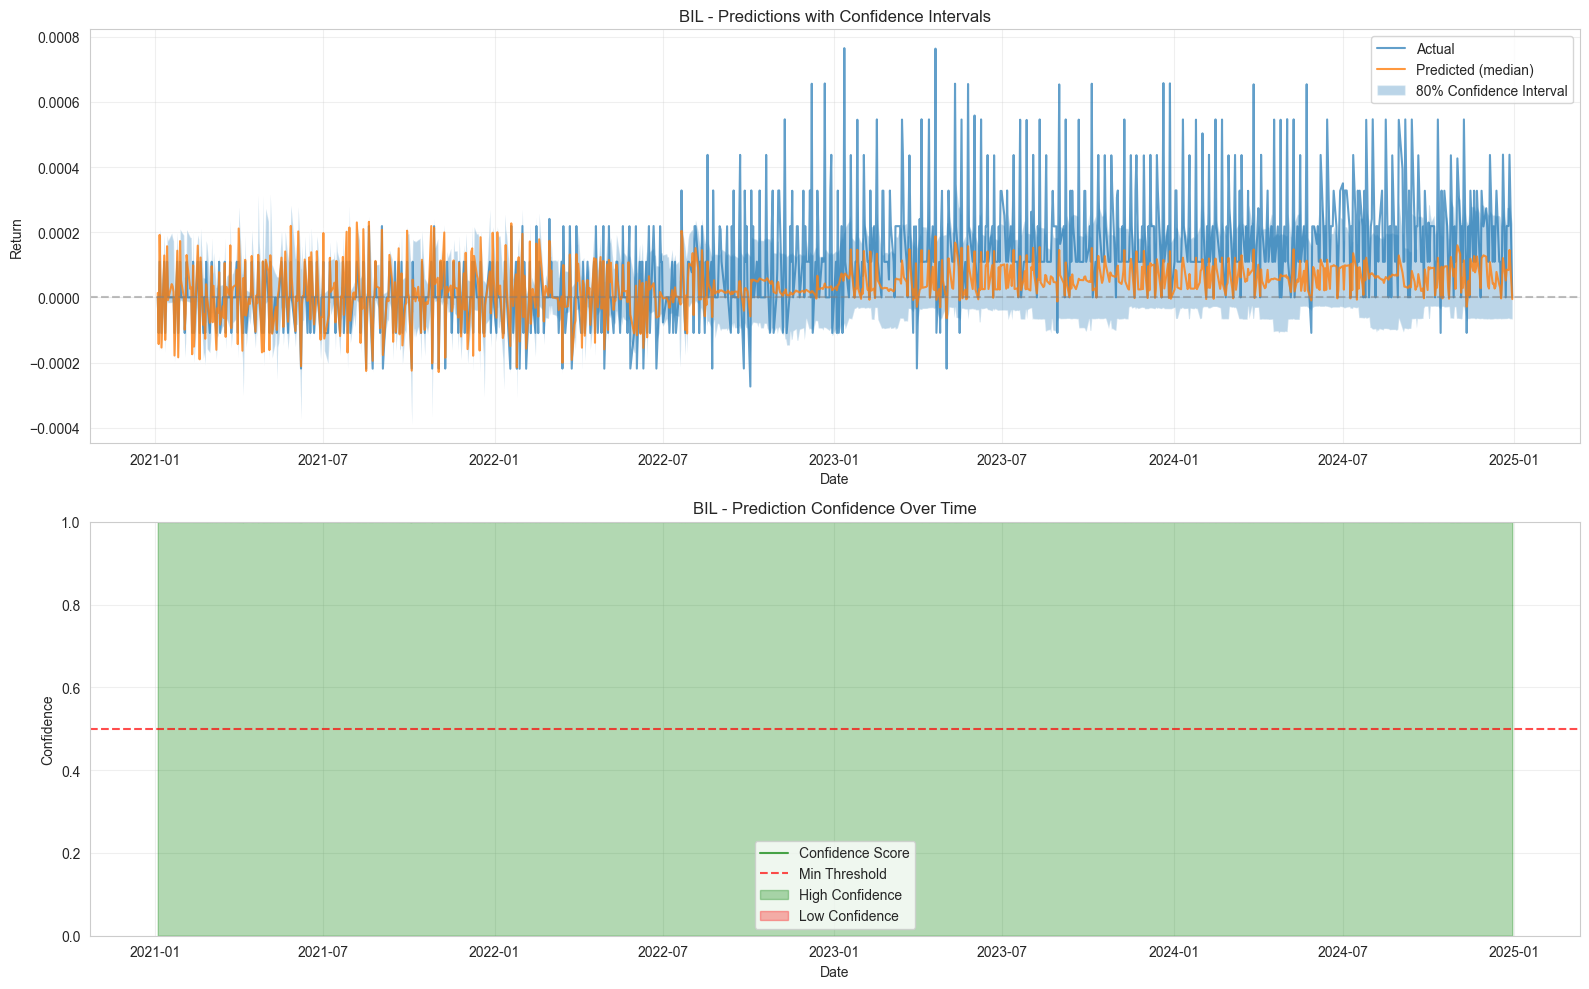

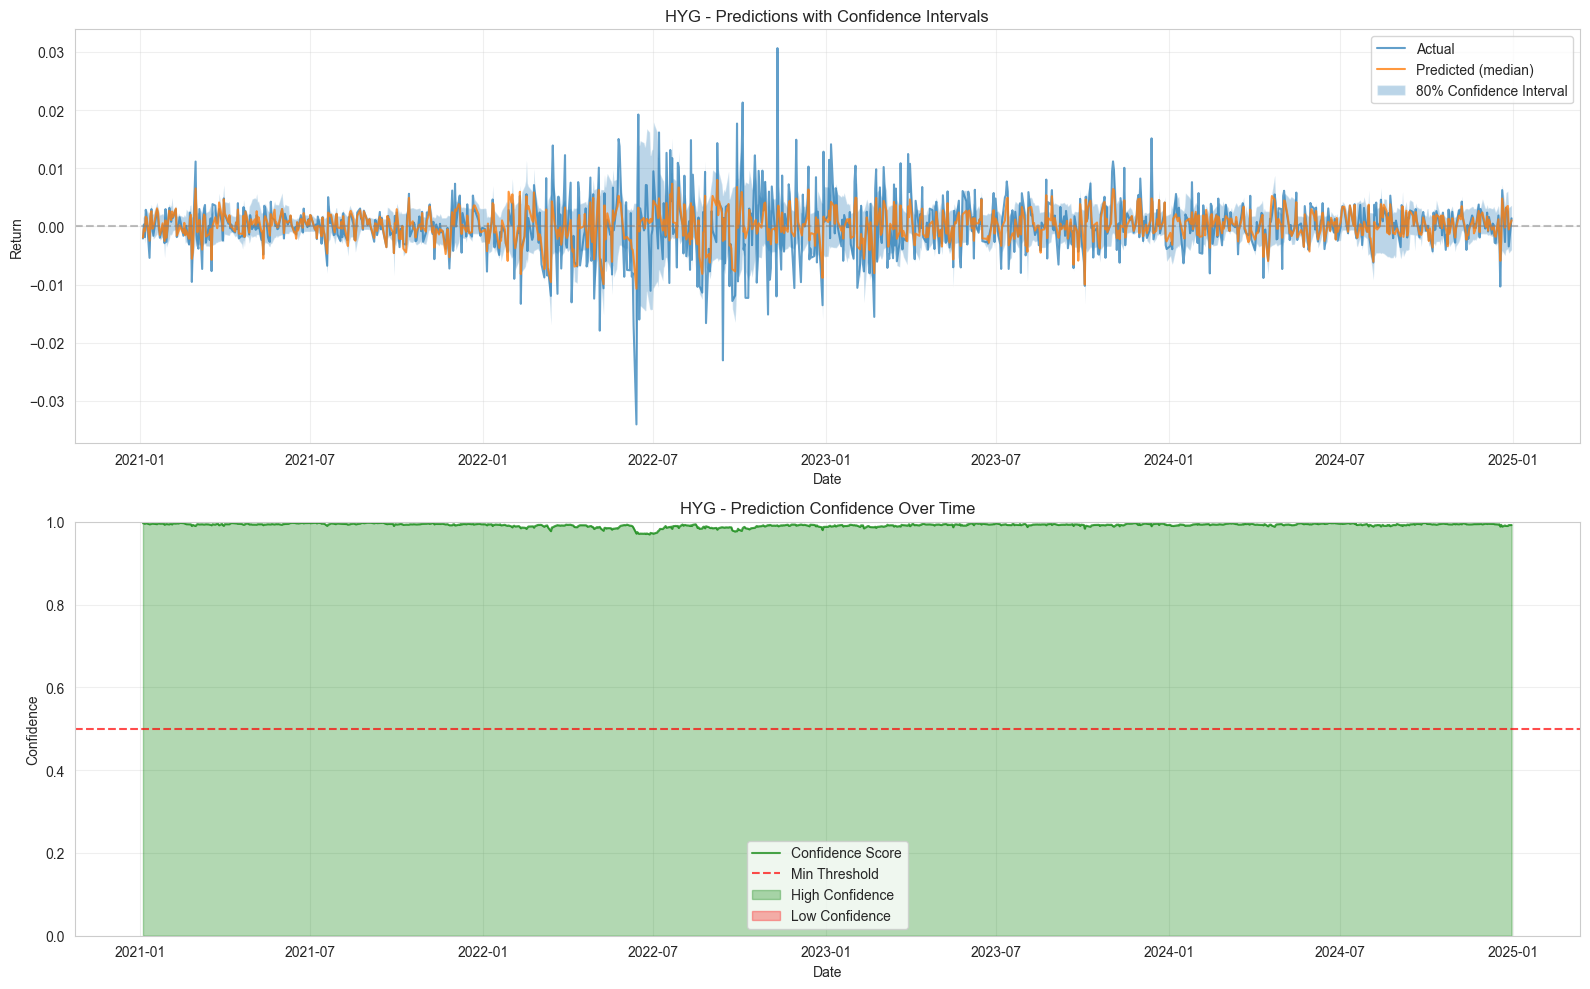

In [10]:
# Visualization: Predictions with confidence intervals
def plot_predictions_with_confidence(asset, results, data_dict):
    """Plot actual vs predicted with confidence intervals."""
    predictions_df = results['predictions']
    y_test = data_dict['y_test']
    dates = data_dict['X_test'].index
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # Plot 1: Time series with confidence bands
    ax = axes[0]
    ax.plot(dates, y_test, label='Actual', alpha=0.7, linewidth=1.5)
    ax.plot(dates, predictions_df['pred_median'], label='Predicted (median)', alpha=0.8, linewidth=1.5)
    ax.fill_between(dates, 
                     predictions_df['pred_lower'], 
                     predictions_df['pred_upper'],
                     alpha=0.3, label='80% Confidence Interval')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Date')
    ax.set_ylabel('Return')
    ax.set_title(f'{asset} - Predictions with Confidence Intervals')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Plot 2: Confidence score over time
    ax = axes[1]
    confidence = predictions_df['confidence']
    ax.plot(dates, confidence, label='Confidence Score', color='green', alpha=0.7)
    ax.axhline(y=CONFIDENCE_CONFIG['min_confidence_threshold'], 
               color='red', linestyle='--', label='Min Threshold', alpha=0.7)
    ax.fill_between(dates, 0, confidence, 
                     where=(confidence >= CONFIDENCE_CONFIG['min_confidence_threshold']),
                     color='green', alpha=0.3, label='High Confidence')
    ax.fill_between(dates, 0, confidence,
                     where=(confidence < CONFIDENCE_CONFIG['min_confidence_threshold']),
                     color='red', alpha=0.3, label='Low Confidence')
    ax.set_xlabel('Date')
    ax.set_ylabel('Confidence')
    ax.set_title(f'{asset} - Prediction Confidence Over Time')
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f'{asset}_confidence_intervals.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plot for first 3 assets
for i, asset in enumerate(list(all_results.keys())[:3]):
    data_dict = load_asset_data(asset)
    plot_predictions_with_confidence(asset, all_results[asset], data_dict)

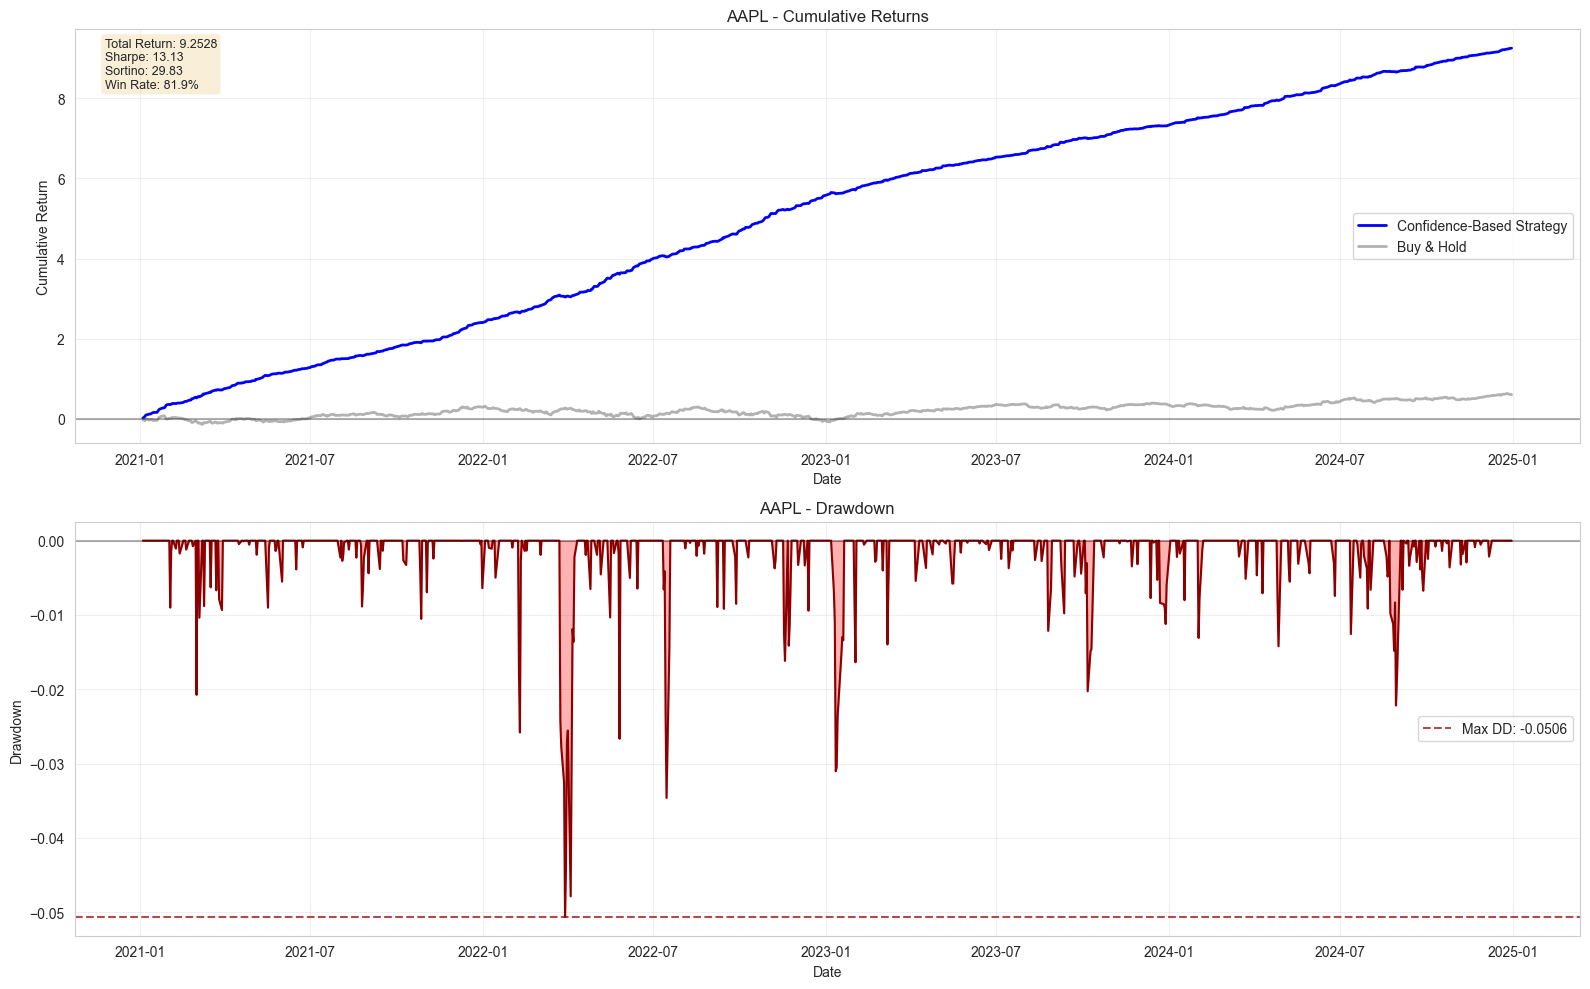

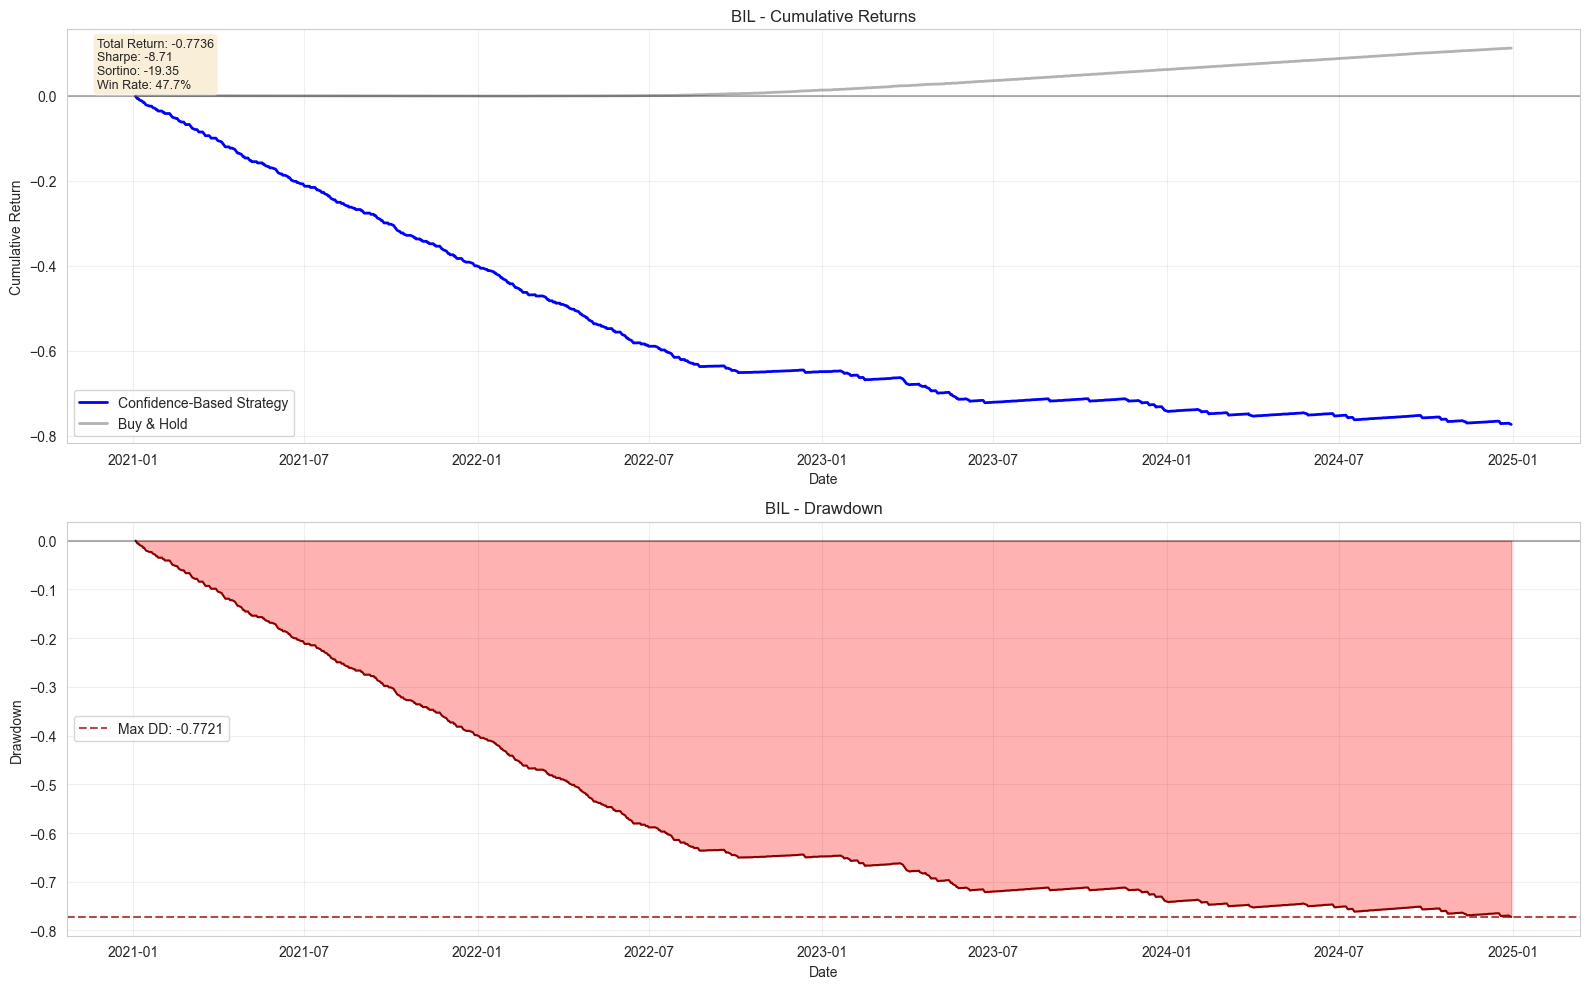

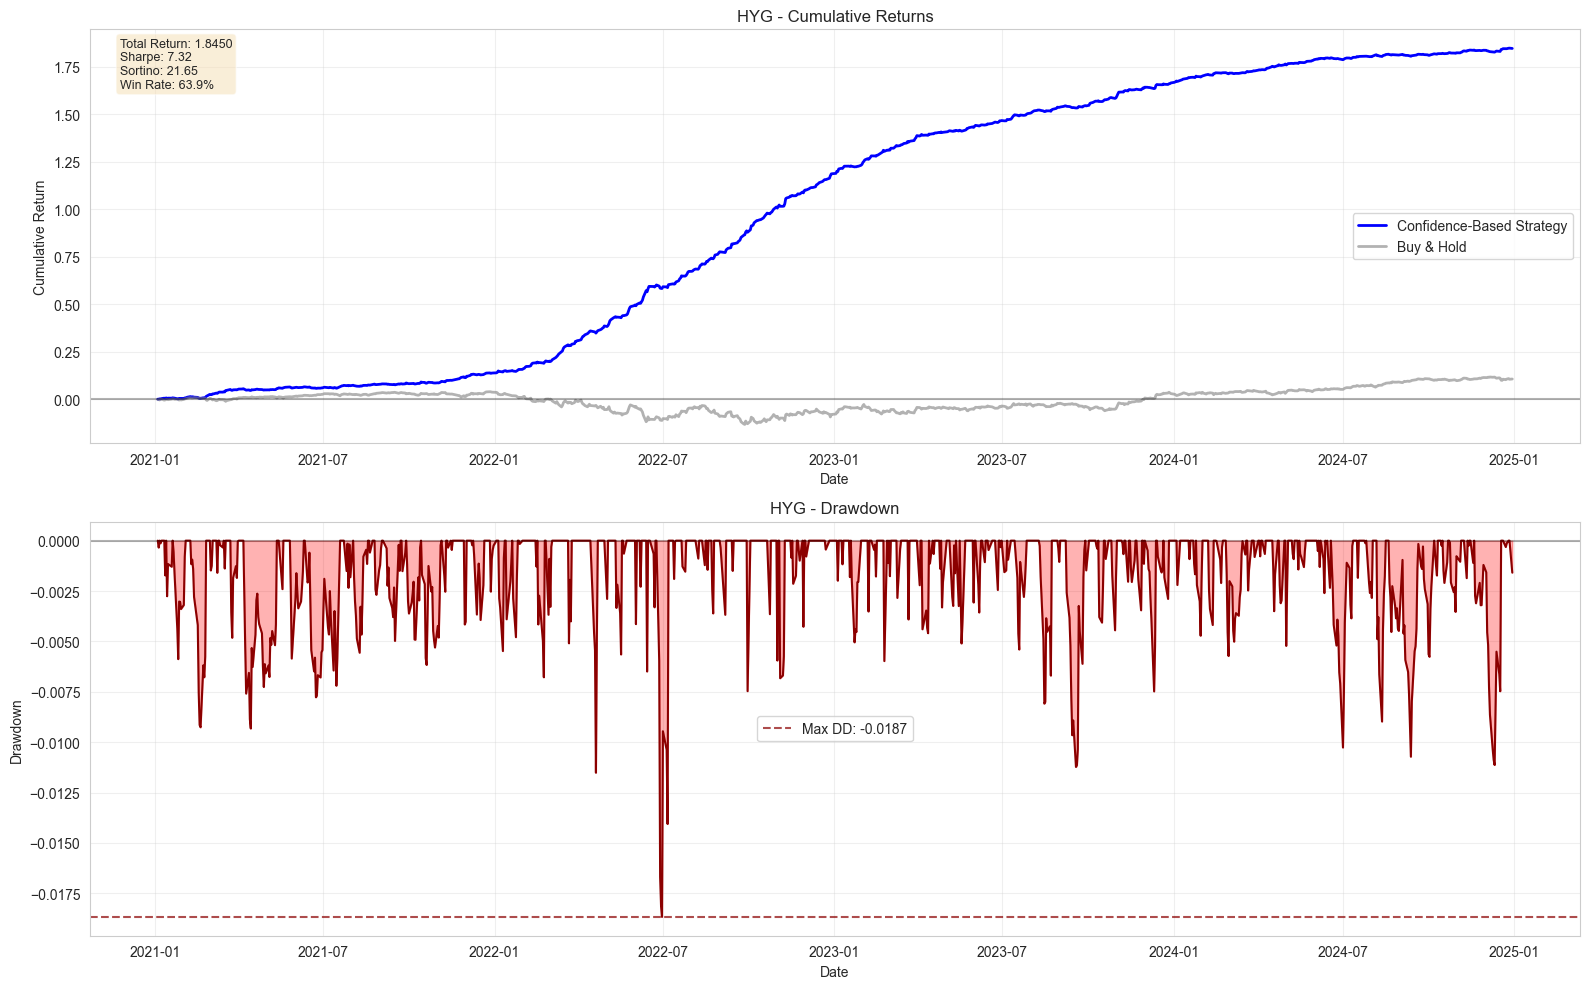

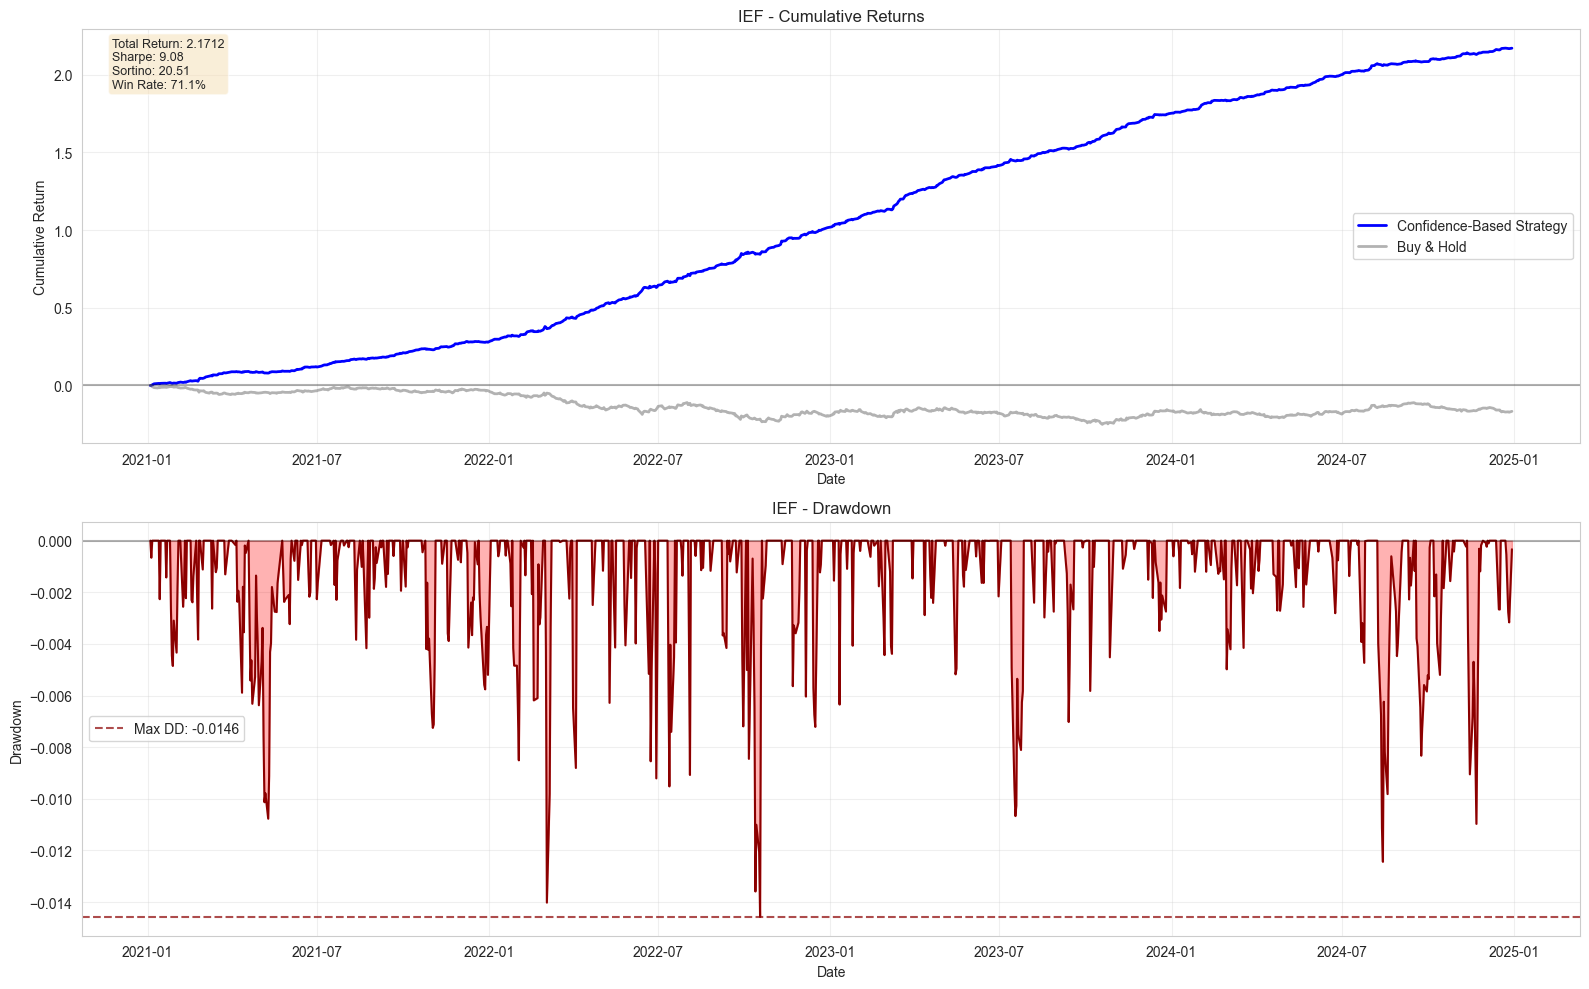

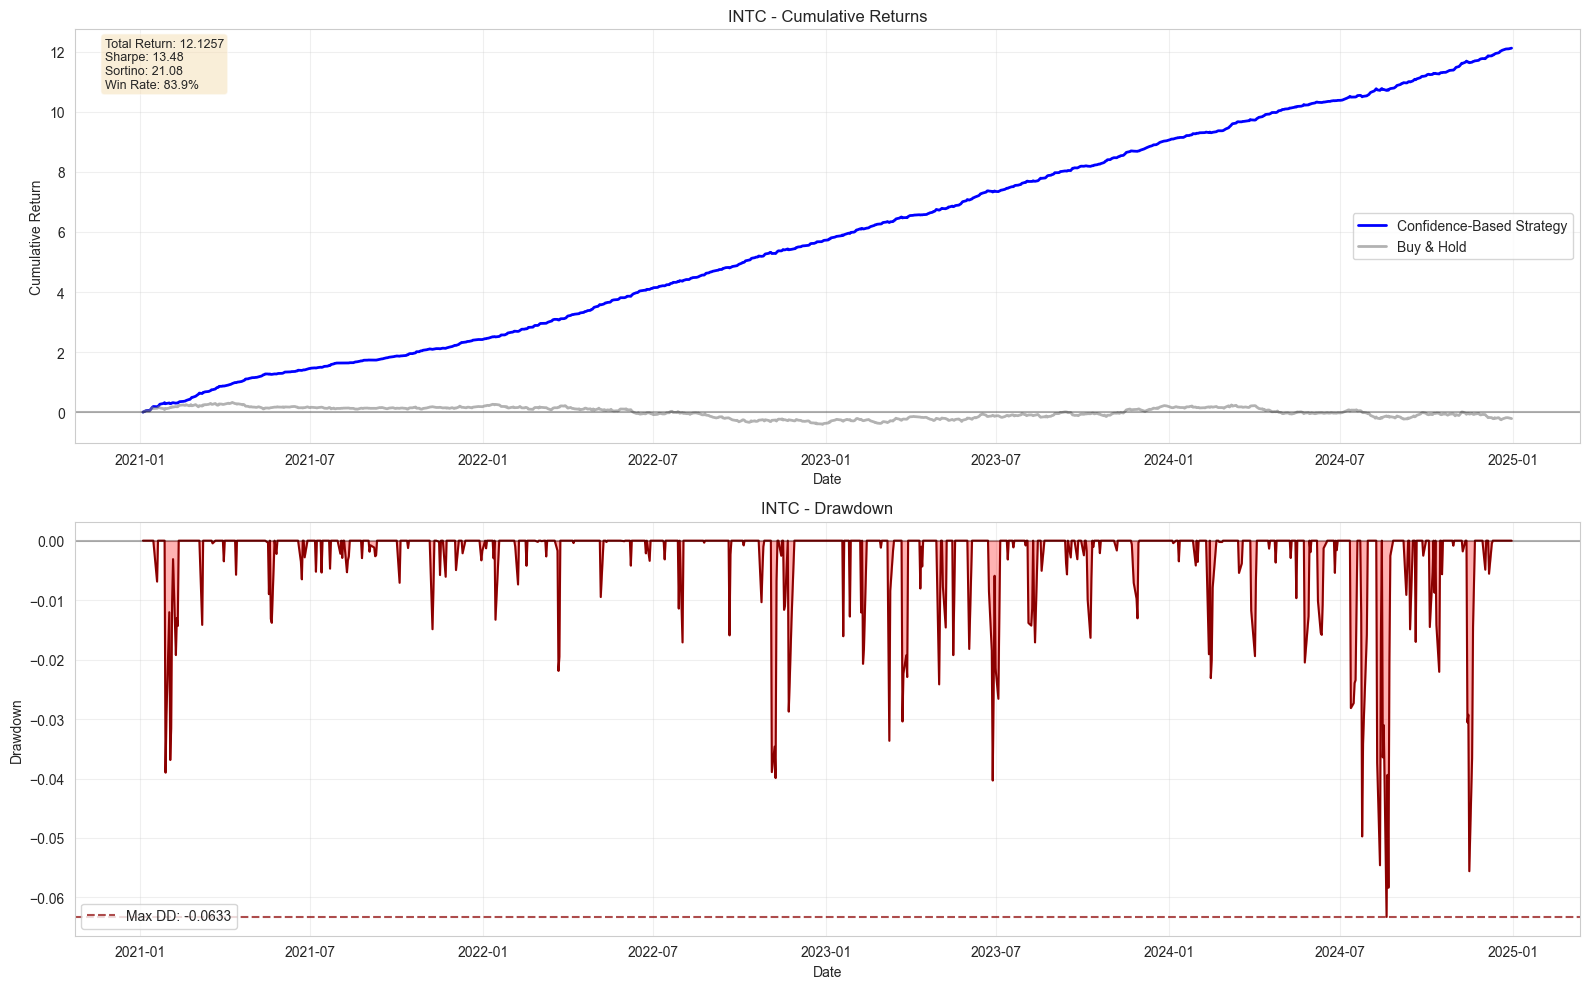

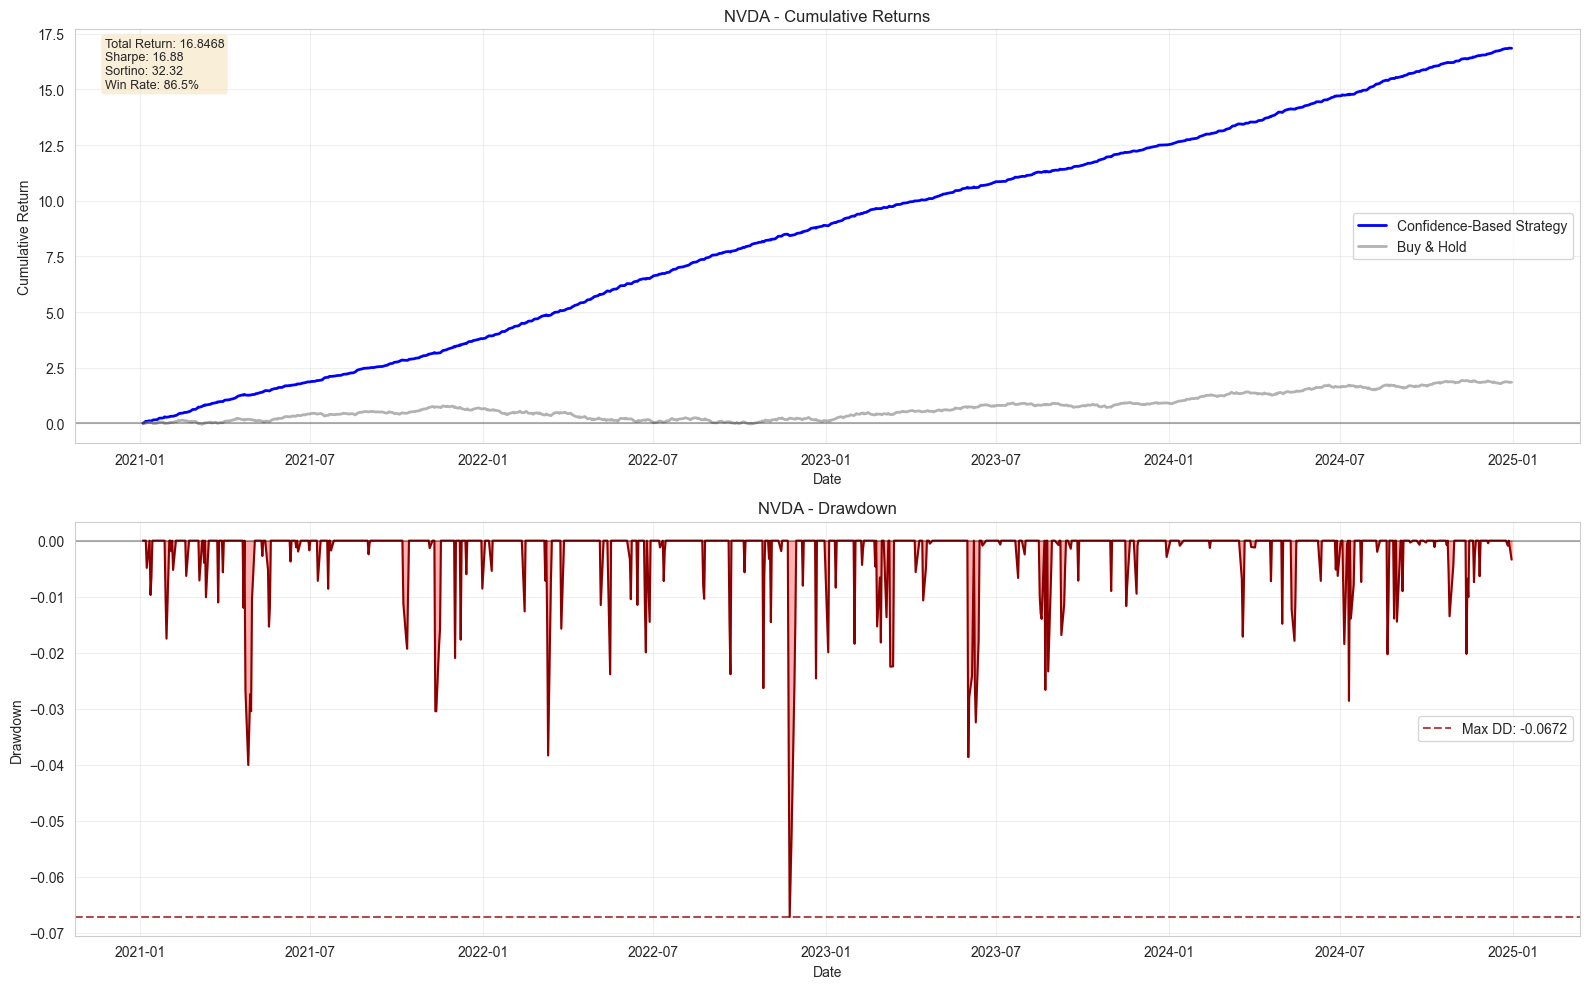

In [11]:
# Visualization: Cumulative returns and drawdown
def plot_cumulative_returns_and_drawdown(asset, results, data_dict):
    """Plot cumulative returns and drawdown curves."""
    trading_results = results['trading_results']
    returns = trading_results['returns']
    dates = data_dict['X_test'].index
    
    # Calculate cumulative returns
    cumulative = np.cumsum(returns)
    
    # Calculate drawdown
    running_max = np.maximum.accumulate(cumulative)
    drawdown = cumulative - running_max
    
    # Calculate buy-and-hold for comparison
    buy_hold = np.cumsum(data_dict['y_test'])
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # Plot 1: Cumulative returns
    ax = axes[0]
    ax.plot(dates, cumulative, label='Confidence-Based Strategy', linewidth=2, color='blue')
    ax.plot(dates, buy_hold, label='Buy & Hold', linewidth=2, alpha=0.6, color='gray')
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return')
    ax.set_title(f'{asset} - Cumulative Returns')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Add metrics text
    metrics = results['metrics']
    metrics_text = (
        f"Total Return: {metrics['total_return']:.4f}\n"
        f"Sharpe: {metrics['sharpe_ratio']:.2f}\n"
        f"Sortino: {metrics['sortino_ratio']:.2f}\n"
        f"Win Rate: {metrics['win_rate']:.1%}"
    )
    ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=9)
    
    # Plot 2: Drawdown
    ax = axes[1]
    ax.fill_between(dates, drawdown, 0, color='red', alpha=0.3)
    ax.plot(dates, drawdown, color='darkred', linewidth=1.5)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax.set_xlabel('Date')
    ax.set_ylabel('Drawdown')
    ax.set_title(f'{asset} - Drawdown')
    ax.grid(alpha=0.3)
    
    # Add max drawdown line
    max_dd = metrics['max_drawdown']
    ax.axhline(y=max_dd, color='darkred', linestyle='--', alpha=0.7, 
               label=f'Max DD: {max_dd:.4f}')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f'{asset}_cumulative_returns.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plot for all assets
for asset in all_results.keys():
    data_dict = load_asset_data(asset)
    plot_cumulative_returns_and_drawdown(asset, all_results[asset], data_dict)

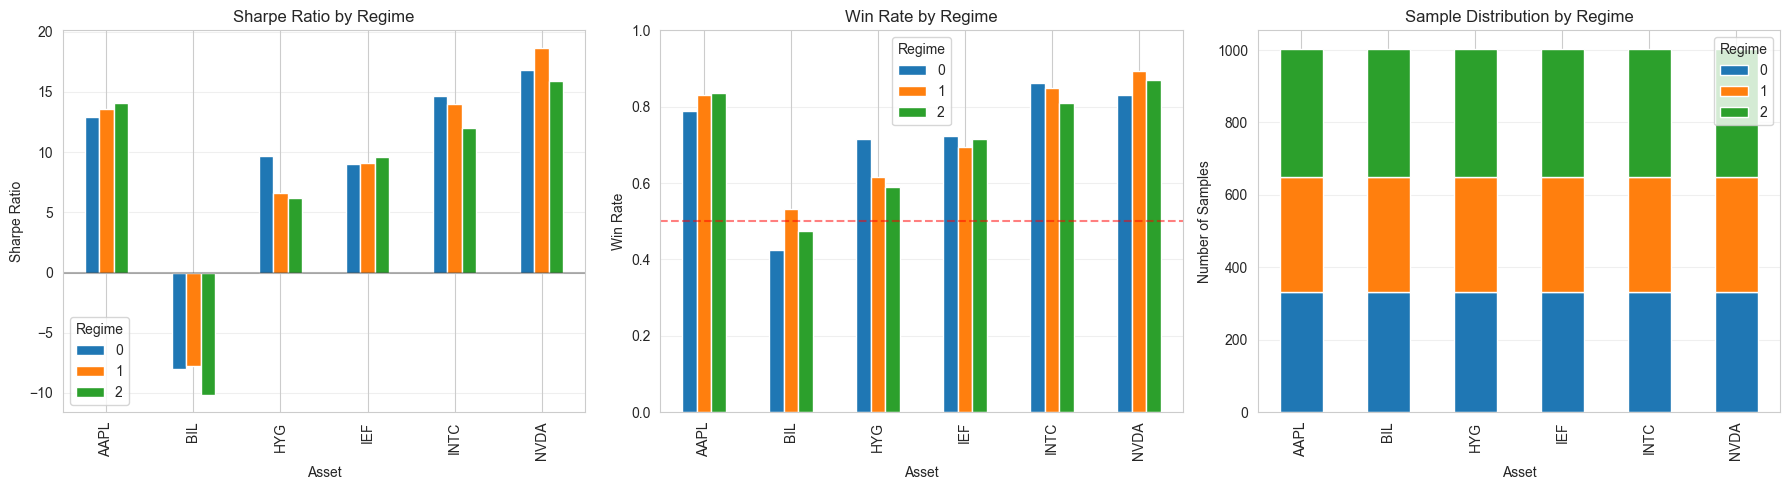


Regime Performance Summary:
   Asset  Regime     Sharpe  Win Rate  Total Return  Samples
0   AAPL       0  12.881817  0.788520      3.672493      331
1   AAPL       1  13.580823  0.829653      2.691742      317
2   AAPL       2  14.046368  0.837079      2.888604      356
3    BIL       0  -8.005427  0.425982     -0.222415      331
4    BIL       1  -7.799548  0.533123     -0.213500      317
5    BIL       2 -10.154552  0.474719     -0.337706      356
6    HYG       0   9.650270  0.716012      1.083563      331
7    HYG       1   6.593314  0.615142      0.382012      317
8    HYG       2   6.166306  0.589888      0.379386      356
9    IEF       0   9.004607  0.722054      0.857951      331
10   IEF       1   9.082108  0.694006      0.619947      317
11   IEF       2   9.609306  0.716292      0.693337      356
12  INTC       0  14.633546  0.861027      4.477487      331
13  INTC       1  14.017719  0.848580      3.918082      317
14  INTC       2  11.985508  0.808989      3.730131     

In [12]:
# Visualization: Regime performance breakdown
def plot_regime_performance(all_results):
    """Compare performance across regimes and assets."""
    regime_data = []
    
    for asset, results in all_results.items():
        predictions_df = results['predictions']
        trading_results = results['trading_results']
        returns = trading_results['returns']
        
        # Group by regime
        for regime_idx in [0, 1, 2]:
            mask = predictions_df['regime'] == regime_idx
            if mask.sum() > 0:
                regime_returns = [returns[i] for i in range(len(returns)) if mask.iloc[i]]
                if regime_returns:
                    regime_metrics = calculate_risk_metrics(regime_returns)
                    regime_data.append({
                        'Asset': asset,
                        'Regime': regime_idx,
                        'Sharpe': regime_metrics['sharpe_ratio'],
                        'Win Rate': regime_metrics['win_rate'],
                        'Total Return': regime_metrics['total_return'],
                        'Samples': len(regime_returns),
                    })
    
    regime_df = pd.DataFrame(regime_data)
    
    # Check if we have data to plot
    if len(regime_df) == 0:
        print("⚠️ No regime data to plot (all predictions may have failed regime detection)")
        print("This usually means regime detection needs to be fixed.")
        return regime_df
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Sharpe by regime
    ax = axes[0]
    pivot_sharpe = regime_df.pivot(index='Asset', columns='Regime', values='Sharpe')
    if not pivot_sharpe.empty:
        pivot_sharpe.plot(kind='bar', ax=ax)
        ax.set_title('Sharpe Ratio by Regime')
        ax.set_ylabel('Sharpe Ratio')
        ax.set_xlabel('Asset')
        ax.legend(title='Regime')
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax.grid(alpha=0.3, axis='y')
    
    # Plot 2: Win rate by regime
    ax = axes[1]
    pivot_winrate = regime_df.pivot(index='Asset', columns='Regime', values='Win Rate')
    if not pivot_winrate.empty:
        pivot_winrate.plot(kind='bar', ax=ax)
        ax.set_title('Win Rate by Regime')
        ax.set_ylabel('Win Rate')
        ax.set_xlabel('Asset')
        ax.legend(title='Regime')
        ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
        ax.grid(alpha=0.3, axis='y')
        ax.set_ylim(0, 1)
    
    # Plot 3: Sample count by regime
    ax = axes[2]
    pivot_samples = regime_df.pivot(index='Asset', columns='Regime', values='Samples')
    if not pivot_samples.empty:
        pivot_samples.plot(kind='bar', ax=ax, stacked=True)
        ax.set_title('Sample Distribution by Regime')
        ax.set_ylabel('Number of Samples')
        ax.set_xlabel('Asset')
        ax.legend(title='Regime')
        ax.grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'regime_performance_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return regime_df

regime_df = plot_regime_performance(all_results)
if len(regime_df) > 0:
    print("\nRegime Performance Summary:")
    print(regime_df.to_string())
else:
    print("\n⚠️ No regime performance data available")
    print("The notebook needs to be re-run with the updated regime detection code.")

In [13]:
# Summary results
summary_data = []

for asset, results in all_results.items():
    metrics = results['metrics']
    pred_metrics = results['prediction_metrics']
    conf_stats = results['confidence_stats']
    
    summary_data.append({
        'Asset': asset,
        'RMSE': pred_metrics['rmse'],
        'R²': pred_metrics['r2'],
        'Dir_Acc': pred_metrics['directional_accuracy'],
        'Total_Return': metrics['total_return'],
        'Sharpe': metrics['sharpe_ratio'],
        'Sortino': metrics['sortino_ratio'],
        'Max_DD': metrics['max_drawdown'],
        'Calmar': metrics['calmar_ratio'],
        'Win_Rate': metrics['win_rate'],
        'Profit_Factor': metrics['profit_factor'],
        'Trades': metrics['num_actual_trades'],
        'Skipped': metrics['skipped_low_confidence'],
        'Costs': metrics['total_transaction_costs'],
        'Mean_Confidence': conf_stats['mean_confidence'],
        'High_Conf_Pct': conf_stats['high_confidence_pct'],
    })

summary_df = pd.DataFrame(summary_data)

# Save summary
summary_df.to_csv(RESULTS_DIR / 'regime_confidence_summary.csv', index=False)

print("\n" + "="*120)
print("REGIME-AWARE & CONFIDENCE-BASED TRADING SUMMARY")
print("="*120)
print(summary_df.to_string(index=False))
print("\n" + "="*120)

# Calculate average metrics
print("\nAverage Performance Across All Assets:")
print(f"  Mean Sharpe Ratio: {summary_df['Sharpe'].mean():.4f}")
print(f"  Mean Sortino Ratio: {summary_df['Sortino'].mean():.4f}")
print(f"  Mean Calmar Ratio: {summary_df['Calmar'].mean():.4f}")
print(f"  Mean Win Rate: {summary_df['Win_Rate'].mean():.2%}")
print(f"  Mean Profit Factor: {summary_df['Profit_Factor'].mean():.4f}")
print(f"  Mean Directional Accuracy: {summary_df['Dir_Acc'].mean():.2%}")
print(f"  Mean Confidence: {summary_df['Mean_Confidence'].mean():.2%}")
print(f"  Mean High Confidence %: {summary_df['High_Conf_Pct'].mean():.2%}")

print(f"\n✓ All results saved to {RESULTS_DIR}")
print(f"✓ All models saved to {OUTPUT_DIR}")


REGIME-AWARE & CONFIDENCE-BASED TRADING SUMMARY
Asset     RMSE       R²  Dir_Acc  Total_Return    Sharpe    Sortino    Max_DD    Calmar  Win_Rate  Profit_Factor  Trades  Skipped    Costs  Mean_Confidence  High_Conf_Pct
 AAPL 0.009543 0.634744 0.853586      9.252839 13.134360  29.831068 -0.050649 45.853563  0.818725      12.028564     391        0 1.141740         0.973840            1.0
  BIL 0.000154 0.211449 0.711155     -0.773620 -8.710577 -19.349267 -0.772120 -0.251484  0.477092       0.123173     306        0 0.916294         0.999756            1.0
  HYG 0.003331 0.557941 0.846614      1.844961  7.321313  21.646192 -0.018674 24.797866  0.639442       4.271196     406        0 1.207390         0.992199            1.0
  IEF 0.003645 0.494951 0.850598      2.171235  9.076456  20.510179 -0.014577 37.386916  0.711155       5.039954     417        0 1.240575         0.992772            1.0
 INTC 0.014020 0.516624 0.858566     12.125700 13.477386  21.076980 -0.063269 48.104279  0.83864

In [14]:
# Save complete metadata
metadata = {
    'creation_date': datetime.now().isoformat(),
    'num_assets': len(all_results),
    'assets': list(all_results.keys()),
    'regime_config': REGIME_CONFIG,
    'quantile_config': QUANTILE_CONFIG,
    'confidence_config': CONFIDENCE_CONFIG,
    'trading_config': TRADING_CONFIG,
    'xgboost_params': XGBOOST_PARAMS,
    'summary_stats': {
        'mean_sharpe': float(summary_df['Sharpe'].mean()),
        'mean_sortino': float(summary_df['Sortino'].mean()),
        'mean_calmar': float(summary_df['Calmar'].mean()),
        'mean_win_rate': float(summary_df['Win_Rate'].mean()),
        'mean_profit_factor': float(summary_df['Profit_Factor'].mean()),
        'mean_confidence': float(summary_df['Mean_Confidence'].mean()),
    },
}

with open(RESULTS_DIR / 'metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("\n✓ Metadata saved")
print("\n" + "="*80)
print("TRAINING COMPLETE")
print("="*80)
print(f"\nResults:")
print(f"  - Models: {OUTPUT_DIR}")
print(f"  - Predictions: {RESULTS_DIR}")
print(f"  - Summary: {RESULTS_DIR / 'regime_confidence_summary.csv'}")
print(f"  - Metadata: {RESULTS_DIR / 'metadata.json'}")


✓ Metadata saved

TRAINING COMPLETE

Results:
  - Models: C:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\regime_confidence
  - Predictions: C:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\results\regime_confidence
  - Summary: C:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\results\regime_confidence\regime_confidence_summary.csv
  - Metadata: C:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\results\regime_confidence\metadata.json
